In [1]:
from correction.data.my_dataloader import WRFDataset
from correction.models.loss import TurbulentMSE
from correction.data.train_test_split import split_train_val_test
from correction.config.config import cfg
import torch.nn as nn
import scipy
import matplotlib.pyplot as plt
import numpy as np
import pickle

Device is: cuda
Running script on local machine
1 draw plots
1 use spt encoding
1 weighted meaner
gauss loss_kernel


In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
batch_size = 32
wrf_vars = ['uvmet10', 'T2']
era_vars=['u10', 'v10', 't2m']
wrf_folder = 'C:\\Users\\Viktor\\Desktop\\wrf_test'
era_folder = 'C:\\Users\\Viktor\\Desktop\\era_test'
# wrf_folder1 = 'C:\\Users\\Viktor\\Desktop\\wrf2gpn_test\\t2'

In [4]:
train_files, val_files, test_files = split_train_val_test(wrf_folder, era_folder, 0.7, 0.1, 0.2)

C:/Users/Viktor/Desktop/wrf_test/wrfout_d01_2019-01-01_000000 C:/Users/Viktor/Desktop/wrf_test/wrfout_d01_2019-01-02_000000
Using dates from 2019-01-01 to 2019-01-02


In [5]:
train_dataset = WRFDataset(train_files[0], train_files[1], use_spatiotemporal_encoding=True, use_time_encoding=True)

2 wrf_files
2 era_files


In [6]:
train_dataset[1][0][0, 5]

masked_array(
  data=[[22.31869507, 22.41192627, 22.50552368, ..., 71.68228149,
         71.95455933, 72.22717285],
        [22.44943237, 22.54278564, 22.63653564, ..., 71.71972656,
         71.99084473, 72.26223755],
        [22.57974243, 22.67324829, 22.76715088, ..., 71.75686646,
         72.02676392, 72.29699707],
        ...,
        [42.13943481, 42.23306274, 42.3269043 , ..., 75.71142578,
         75.85305786, 75.99475098],
        [42.20687866, 42.30044556, 42.39419556, ..., 75.72146606,
         75.86276245, 76.00411987],
        [42.2741394 , 42.36761475, 42.46130371, ..., 75.73144531,
         75.87240601, 76.01342773]],
  mask=False,
  fill_value=1e+20)

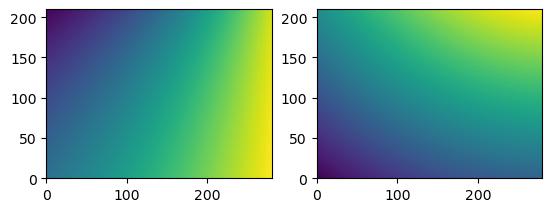

In [7]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_dataset[1][0][0, 5], interpolation='none', extent=[0,280,0,210])
axs[1].imshow(train_dataset[1][0][0, 4], interpolation='none', extent=[0,280,0,210])

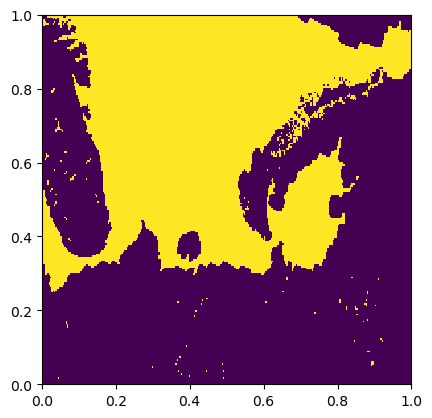

In [9]:
plt.imshow(train_dataset[1][0][0, 3]==0, interpolation='none', extent=[0,1,0,1])

In [12]:
mask = train_dataset[1][0][0, 5]*(train_dataset[1][0][0, 3]==0)

In [13]:
wrf = train_dataset[12][0]
wrfdata = torch.from_numpy(wrf.data)

In [60]:
class GaussianLayer(nn.Module):
    def __init__(self, k=21):
        super(GaussianLayer, self).__init__()
        self.seq = nn.Conv2d(3, 3, k, stride=1, padding=k//2, bias=False, groups=3, padding_mode='replicate')
        self.k = k
        self.weights_init()

    def forward(self, x):
        return self.seq(x)

    def weights_init(self):
        n = np.zeros((self.k, self.k))
        n[self.k//2, self.k//2] = 1
        kk = scipy.ndimage.gaussian_filter(n, sigma=3)
        for name, f in self.named_parameters():
            f.data.copy_(torch.from_numpy(kk))

In [61]:
layer = GaussianLayer(21).float()

In [62]:
layer.seq.weight.size()

torch.Size([3, 1, 21, 21])

In [63]:
wrfdata.dtype

torch.float64

In [64]:
def get_delta_wrf(k, wrf):
    l = GaussianLayer(k).float()
    return (wrf.float() - l(wrf.float())).detach()

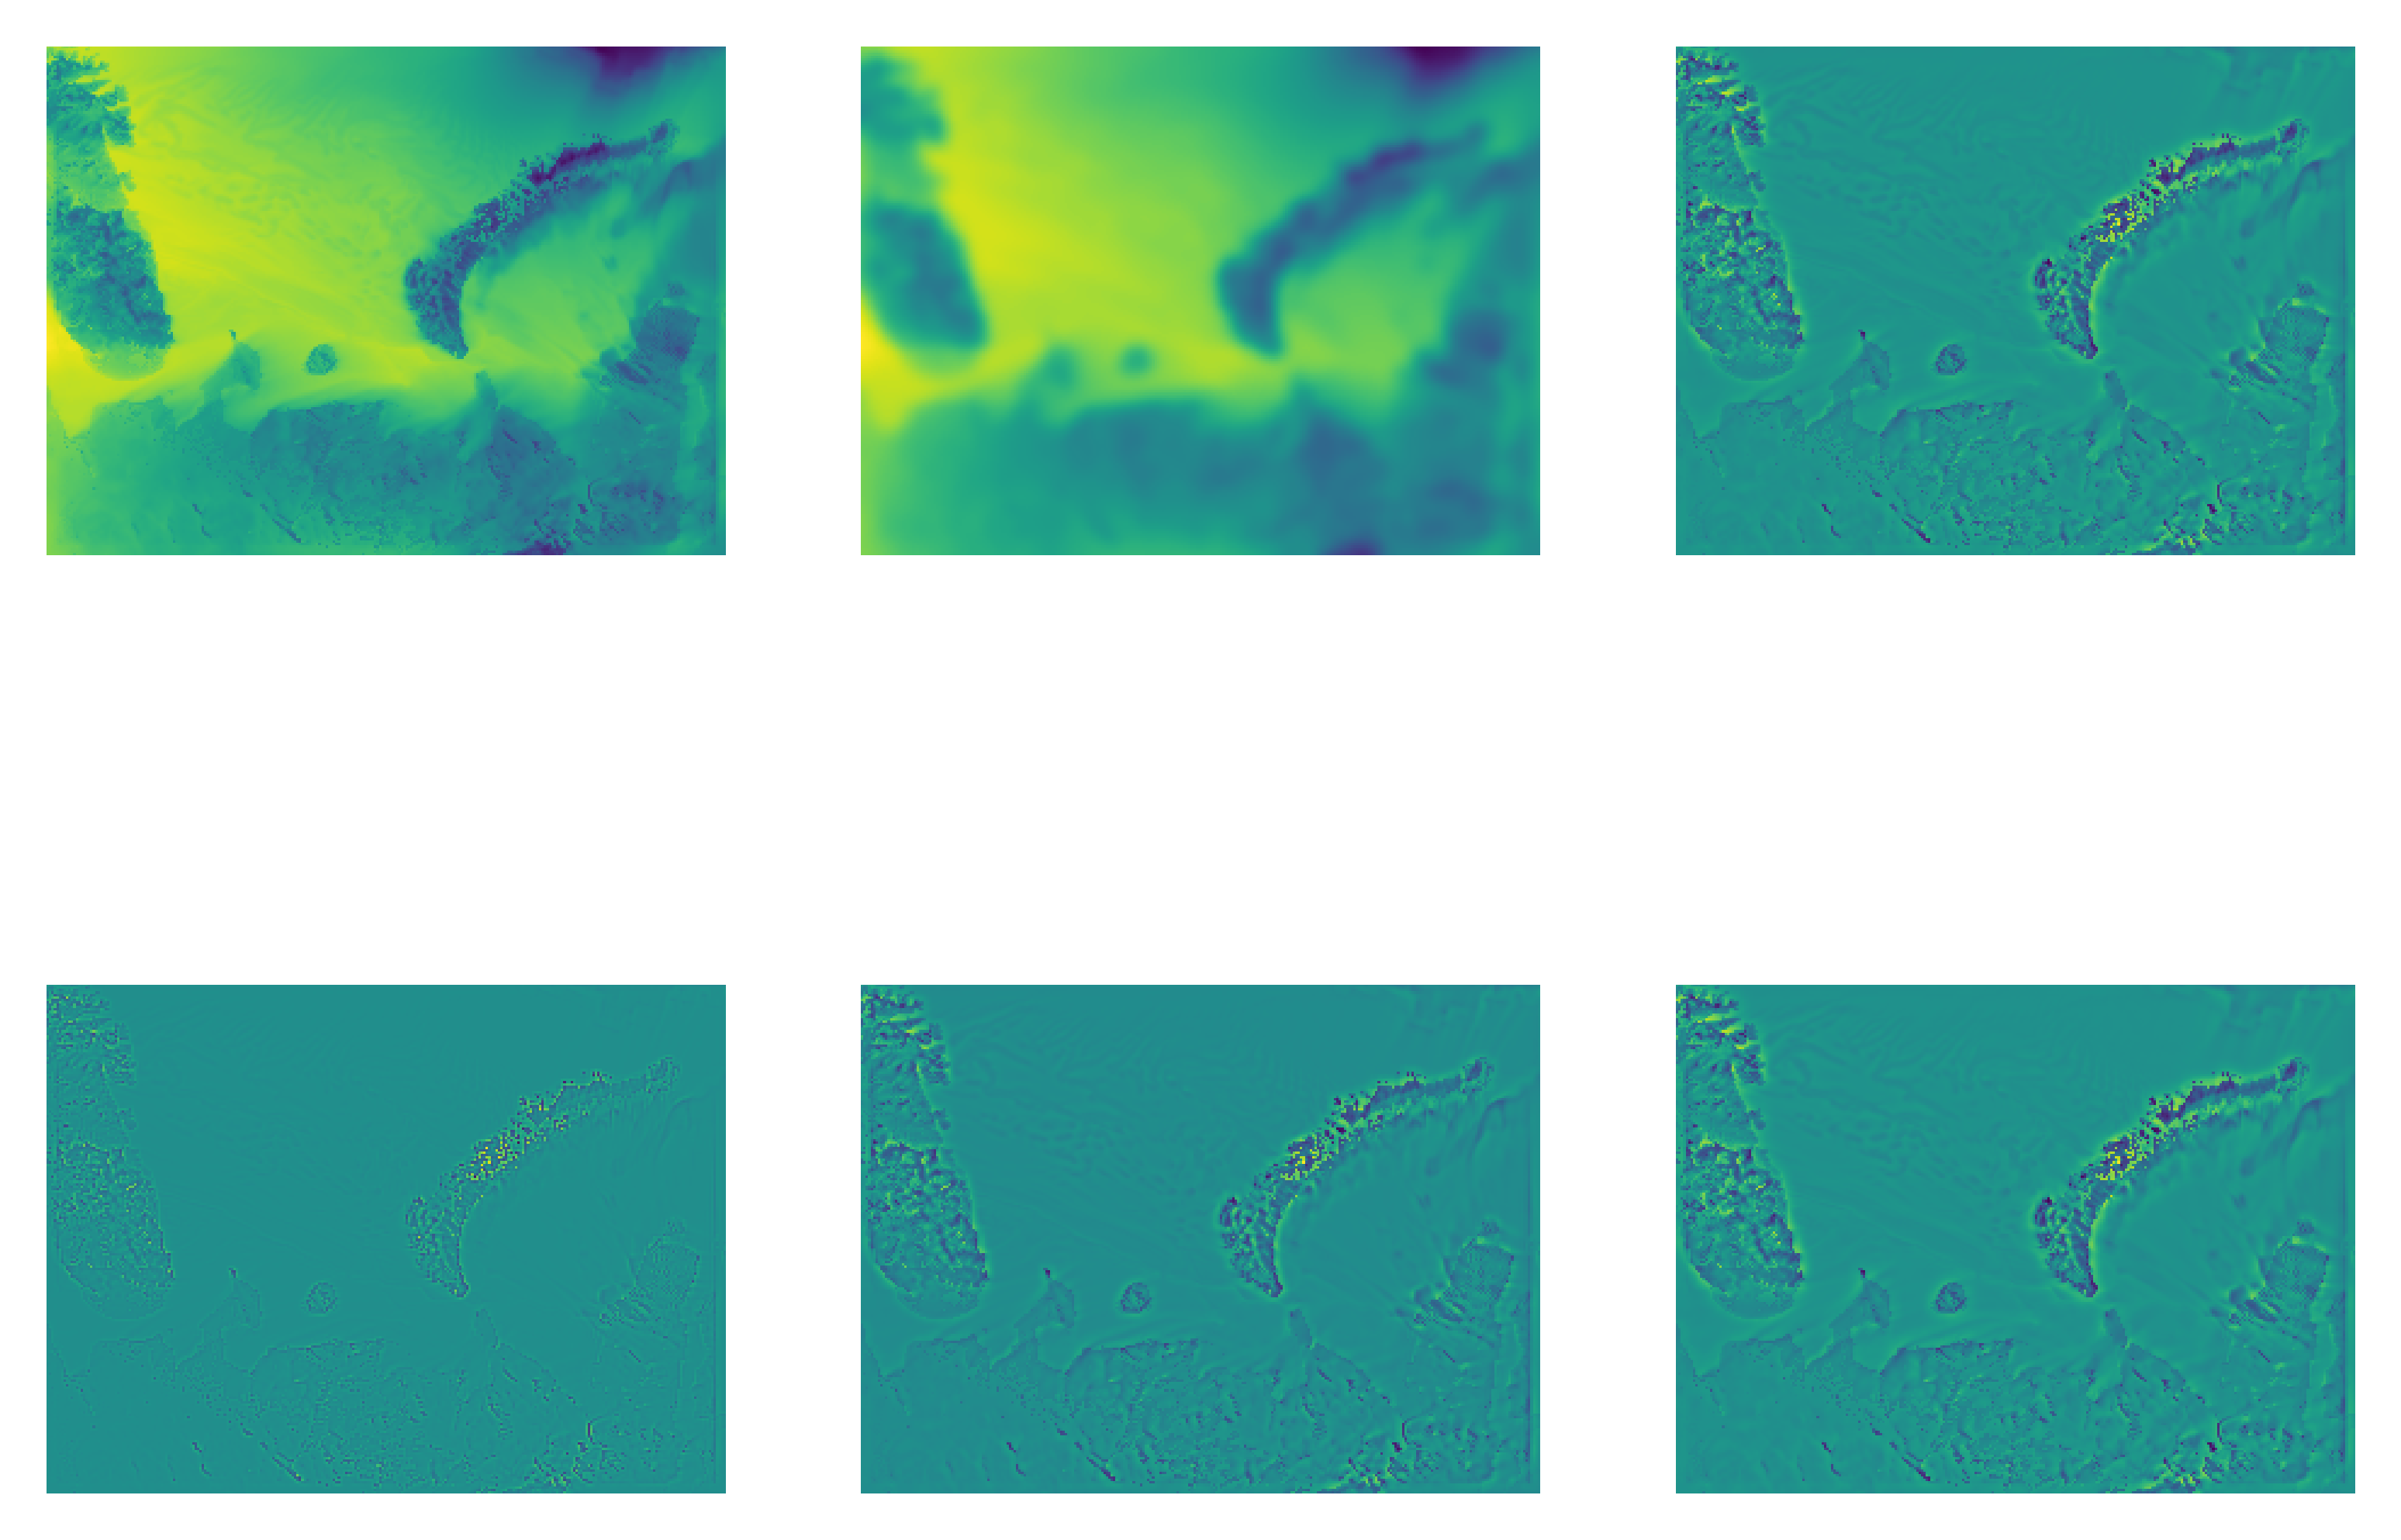

In [67]:
fig, axs = plt.subplots(2, 3, dpi=600)
c = 2
# im = plt.imshow(layer(wrfd[:, :3])[0, 2].numpy())
# im = plt.imshow((wrfd[:, :3]-layer(wrfd[:, :3]))[0, 0].numpy())
axs[0][0].set_axis_off()
axs[0][1].set_axis_off()
axs[0][2].set_axis_off()
im0 = axs[0][0].imshow(wrfdata[:, :3][0, c])
im1 = axs[0][1].imshow(layer(wrfdata[:, :3].float())[0, c].detach())
im2 = axs[0][2].imshow((wrfdata[:, :3][0, c] - layer(wrfdata[:, :3].float())[0, c]).detach())

axs[1][0].set_axis_off()
axs[1][1].set_axis_off()
axs[1][2].set_axis_off()
im2 = axs[1][0].imshow(get_delta_wrf(3, wrfdata[:, :3])[0, c].numpy())
im2 = axs[1][1].imshow(get_delta_wrf(7, wrfdata[:, :3])[0, c].numpy())
im2 = axs[1][2].imshow(get_delta_wrf(11, wrfdata[:, :3])[0, c].numpy())

# fig.colorbar(im1, orientation='vertical')
# fig.colorbar(im2, orientation='vertical')

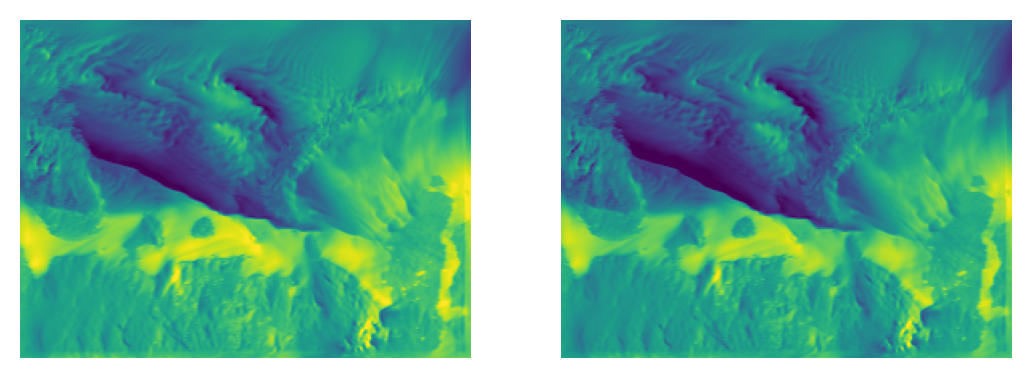

In [195]:
fig, axs = plt.subplots(1, 2, dpi=200)

# im = plt.imshow(layer(wrfd[:, :3])[0, 2].numpy())
# im = plt.imshow((wrfd[:, :3]-layer(wrfd[:, :3]))[0, 0].numpy())
axs[0].set_axis_off()
axs[1].set_axis_off()
vmin, vmax = -10, +10
im0 = axs[0].imshow(wrfd[:, :3][0, 0].numpy(), vmin=vmin, vmax=vmax)
im2 = axs[1].imshow((wrfd[:, :3]-wrfd[:, :3].mean(dim=(-1, -2))[:,:, None, None])[0, 0].numpy(),vmin=vmin, vmax=vmax)

-11.916459083557129 12.277414321899414 1.0055152423841522
-14.518040657043457 12.87357234954834 -0.9534894873619527
242.63848876953125 274.8406982421875 263.09785115508
0.0 1.0 0.5696088435374149
62.22972869873047 78.75765991210938 70.55977967502308
22.318695068359375 76.013427734375 51.56884701320103
-0.9997863151782553 0.9999870986601385 0.05432544699665557
-0.9999678989505117 1.0 0.002923087546359826


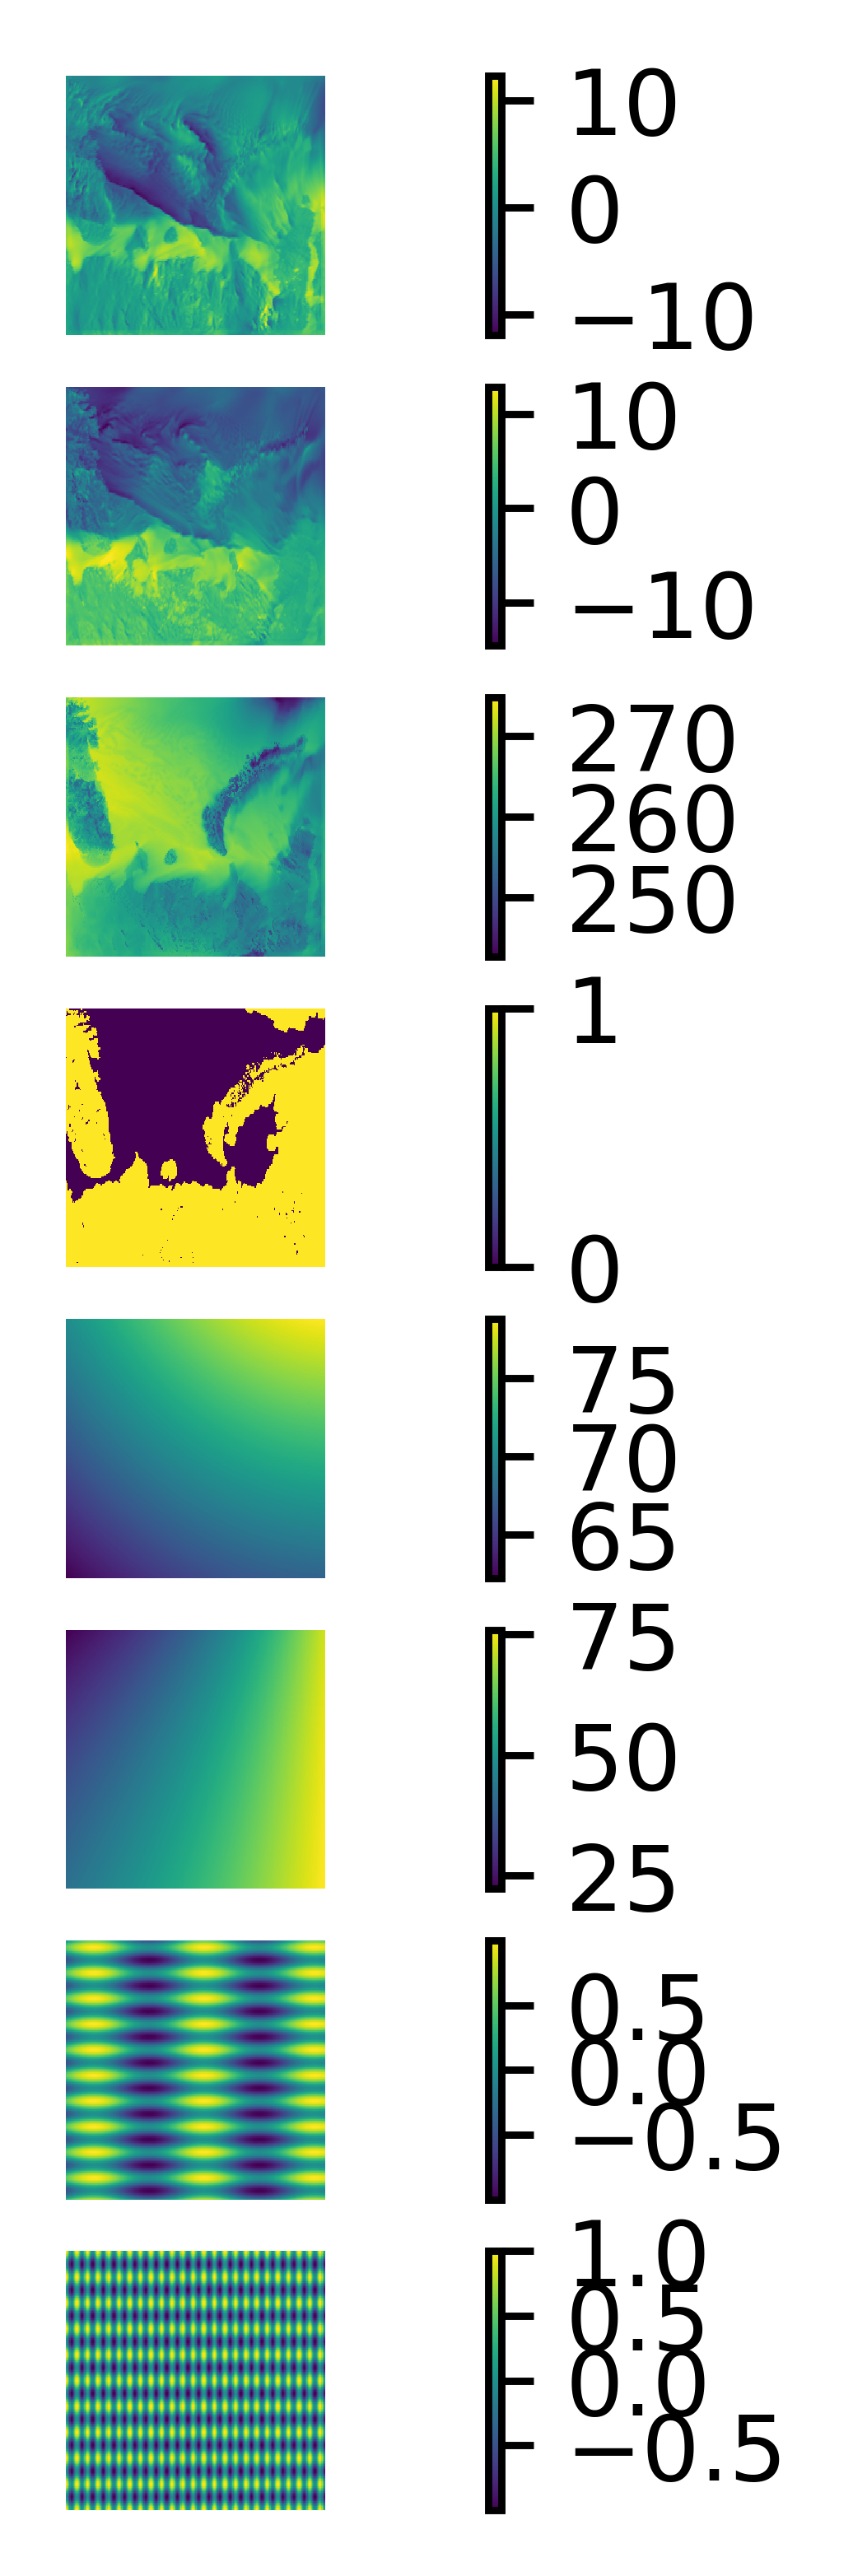

In [7]:

wrf = train_dataset[12][0]
c = wrf.shape[1]
fig, axs = plt.subplots(c, dpi=800)
for j in range(c):
    axs[j].set_axis_off()
    im1 = axs[j].imshow(wrf[0, j], interpolation='none', extent=[0,1,0,1])
    print(wrf[0, j].min(), wrf[0, j].max(), wrf[0, j].mean())
    fig.colorbar(im1, orientation='vertical')


(1, 4, 210, 280) (1, 4, 210, 280) (4, 6, 210, 280)
(1, 4, 210, 280) (1, 4, 210, 280) (4, 6, 210, 280)
(4, 8, 210, 280) (4, 3, 67, 215)
(1, 4, 210, 280) (1, 4, 210, 280) (4, 6, 210, 280)
(1, 4, 210, 280) (1, 4, 210, 280) (4, 6, 210, 280)
248.63396170990166 274.06496183504737 264.3677041065683
242.63848876953125 274.8406982421875 263.09785115508


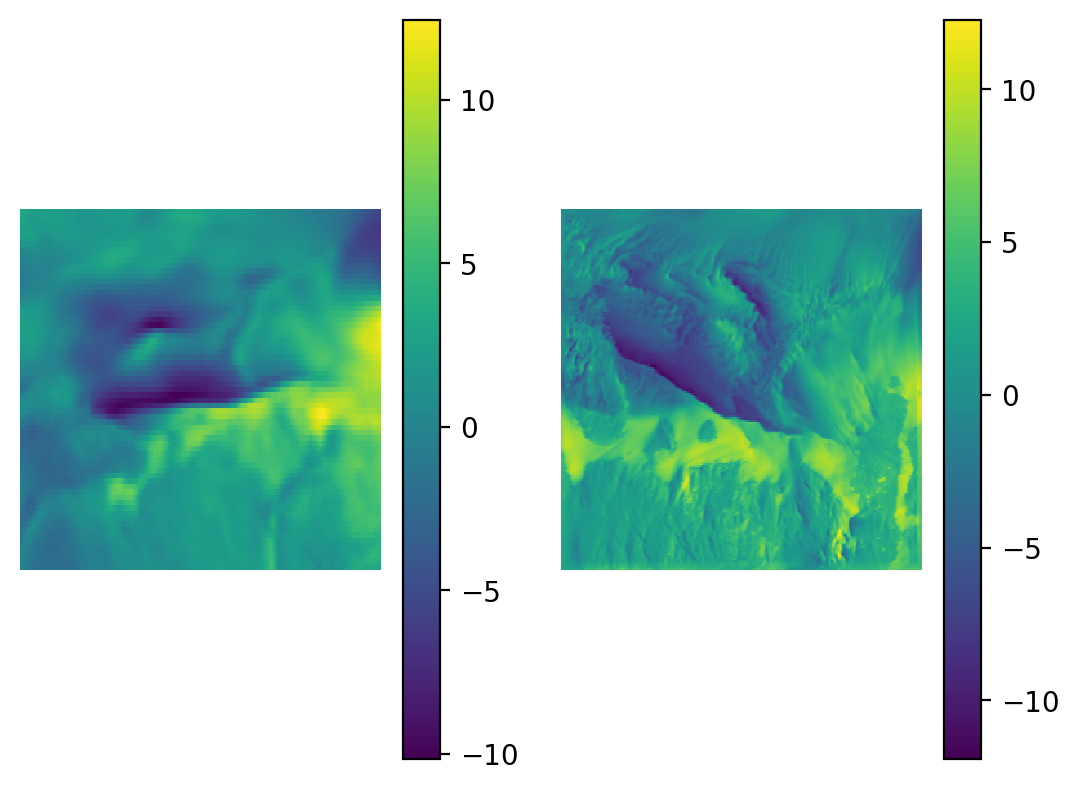

In [7]:

for i in range(12, len(train_dataset)):
    print(train_dataset[i][0].shape, train_dataset[i][1].shape)
    wrf  = train_dataset[i][0]
    era = train_dataset[i][1]
    fig, axs = plt.subplots(1, 2, dpi=200)
    axs[0].set_axis_off()
    axs[1].set_axis_off()
    im1 = axs[0].imshow(era[0, 0], interpolation='none', extent=[0,1,0,1])
    im2 = axs[1].imshow(wrf[0, 0], interpolation='none', extent=[0,1,0,1])
    print(era[0, 2].min(), era[0, 2].max(), era[0, 2].mean())
    print(wrf[0, 2].min(), wrf[0, 2].max(), wrf[0, 2].mean())
    fig.colorbar(im1, orientation='vertical')
    fig.colorbar(im2, orientation='vertical')
    break

In [27]:
from correction.hko.scalers import StandardScaler
import os
era_scaler = StandardScaler()
wrf_scaler = StandardScaler()
era_scaler.apply_scaler_channel_params(torch.load(os.path.join('logs', 'era_means')),
                                       torch.load(os.path.join('logs', 'era_stds')))
wrf_scaler.apply_scaler_channel_params(torch.load(os.path.join('logs', 'wrf_means')),
                                       torch.load(os.path.join('logs', 'wrf_stds')))
train_data = wrf_scaler.channel_transform(torch.from_numpy(train_dataset[1][0]), 1)
train_label = era_scaler.channel_transform(torch.from_numpy(train_dataset[1][1]), 1)

tensor(62.2297) tensor(2.7228) tensor(0.3126)


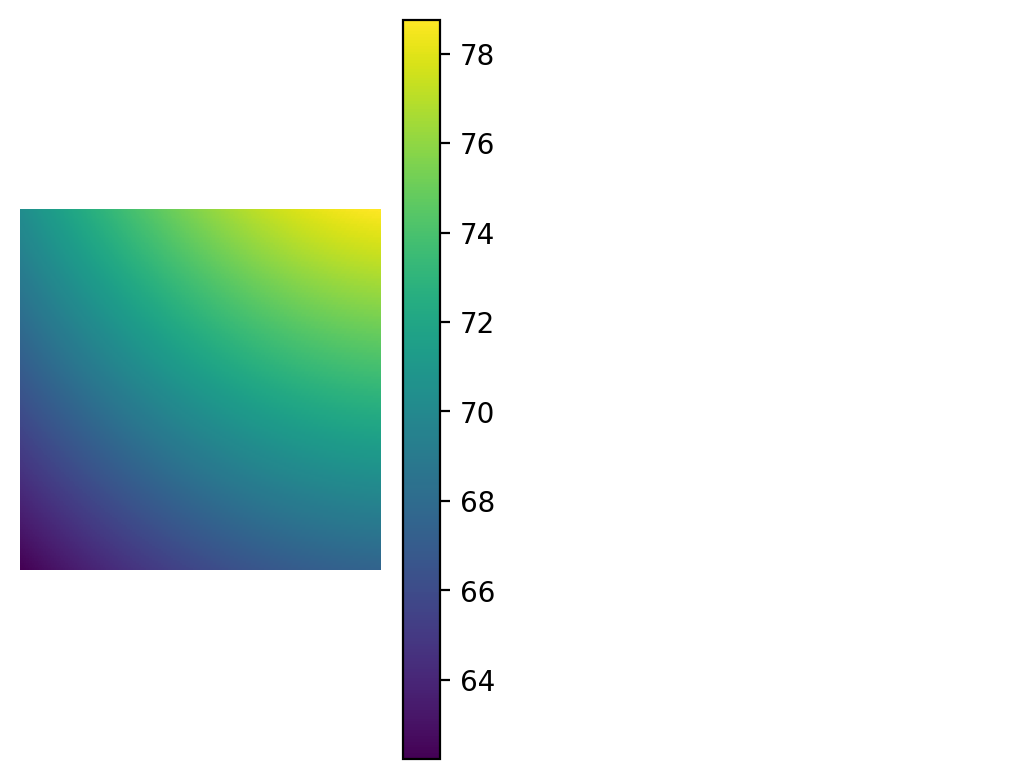

In [49]:
field_id = 4
fig, axs = plt.subplots(1, 2, dpi=200)
axs[0].set_axis_off()
axs[1].set_axis_off()
im1 = axs[0].imshow(train_data[0, field_id], interpolation='none', extent=[0,1,0,1])
# im2 = axs[1].imshow(train_label[0, field_id], interpolation='none', extent=[0,1,0,1])
print(train_data[0, field_id].min(), train_data[0, 0].max(), train_data[0, 0].mean())
# print(train_label[0, field_id].min(), train_label[0, 0].max(), train_label[0, 0].mean())
fig.colorbar(im1, orientation='vertical')
# fig.colorbar(im2, orientation='vertical')

In [1]:
import torch

In [10]:
i = torch.ones([4, 3, 210, 280])

In [11]:
for ii in torch.split(i, 3, dim=-3):
    print(ii.shape)

torch.Size([4, 3, 210, 280])
